# Bike Data Analysis
## Introduction
Developers now need to consider a wider range of options to deal with the transport impacts of a development. As Impact Assessors, it is also essential to analyse how access transit and transportation networks will affect the outcome and impact of an urban development project. A key consideration when pursuing an urban development proposal is to understand site accessibility by all modes of transport, with initial emphasis on walk, cycling and public transport.

Such measures may include the preparation of a Travel Plan, financial incentives to encourage alternatives to private car use, infrastructure improvements to make walking and cycling more attractive or public transport service improvements. Some aspects of the Traffic Impact Assessment approach are still relevant to Transport Assessment since most new developments will result in increased traffic in the immediate locality. 

## Steps of analysis
1. Reading all the trip data into Python
    - *Task 1*: describing what the data looks like and what it shows. 
2. Cleaning the data
    - *Task 2*: describing what the data looks like and what it shows. 
- Adding geographic information
- Creating a Network of trips
- Busy Bike Analysis
- Popular trips on the network
- Predicting capacity of a bike station

Lets go!

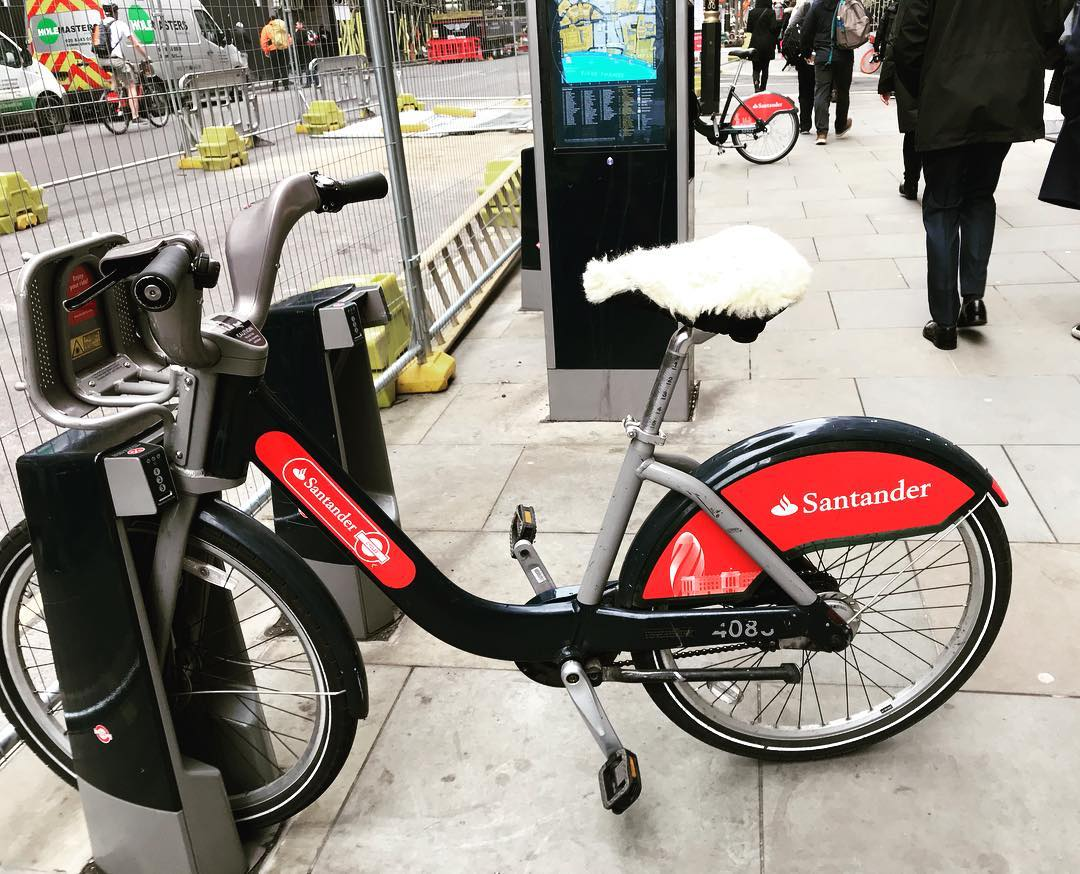

In [1]:
# FYI, a cool library that allows you to visualise images (from URL) inline in Jupyter!
from IPython.display import Image
url = 'https://www.santandercycles.co.uk/sites/default/files/social_content/instagram/53378081_397953404098620_8330148708076807108_n.jpg'
Image(url)

## Santander Cycling data

As part of the free transport data service, Transport for London (TfL) Santander Cycles. The data goes back to January 2012, showing information on the start and end locations of the journey, along with duration and time of day. By combining this information with the coordinates of each cycle hire point, I describe the popularity of routes and the most active stations on the network. The purpose of this analysis it to showcase how metwork analysis and machine learning can help identify important development opportunities in large urban spaces.

For analysis of the full network data (over 48 million trips from 2012-2016) and the technical details, see the Python notebook on my github [here](https://github.com/ChristinaLast/Santander_bike_analysis).

### Reading in bike data for December 2016
Before we can read in any data, we need to load in the appropriate libraries to perform this analysis.

In [2]:
#importing all relevant libraries for the analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

import json
from xml.etree import ElementTree as ET
import requests
from io import BytesIO
from io import StringIO

from zipfile import ZipFile
import urllib.request
from urllib.request import urlopen
import os
from pandas.io.json import json_normalize
import itertools
from itertools import chain, starmap
import codecs

### 1. Reading in the journey data
The TfL bike usage data is hosted as a number of CSV files on their [website](https://cycling.data.tfl.gov.uk/). I can only download results from 2012-2016 because TfL do not standardise the data coding, and webscraping is impossible as data is hidden. 

In [3]:
#Reading the zipped url of 2016's 
bike_data_2016_zip = urllib.request.urlopen("https://cycling.data.tfl.gov.uk/usage-stats/2016TripDataZip.zip")

In [4]:
# Define function to parse zipfiles to dataframe
def zipfile_to_df(url): 
    '''
    This function reads a url containing a zipped folder,
    inside which contains a series of .csv files with trip 
    data from 2016 for all Santander Bikes.
    
    The function performs the following actions:
    1. Reads the URL of a zipfile containing the .csv
    documents containing 2016 bike activity data.
    2. Creating an list to store the dataframes which the 
    .csv's will be imported to.
    3. Iterating through .csv's that match the name in the 
    zipfile and the reading the csv as a dataframe using pandas.
    4. Appending each dataframe to the list.
    5. Concatenating the dataframes in the dataframe list and 
    storing in an object called "data".
    '''
    #Reads the URL of a zipfile containing the .csv documents containing 2016 bike activity data.
    with ZipFile(BytesIO(url.read())) as zipfile:
        # Creating an array to store the dataframes which the .csv's will be imported to.
        dfs = []
        # Iterating through .csv's that match the name in the zipfile 
        for col_name in zipfile.namelist():
            # the reading the csv as a dataframe using pandas.
            with zipfile.open(col_name) as csv:
                df = pd.read_csv(csv, index_col=None, header=0, encoding='latin1')
                # Appending each dataframe to the array.
                dfs.append(df)
    # Concatenating the dataframes in the dataframe array and storing in an object called "data".
    data = pd.concat(dfs, ignore_index=True)
    
    return data

In [5]:
# This runs the function "zipfile_to_df()" and stores to an object "bike_2016_df" 
bike_2016_df = zipfile_to_df(bike_data_2016_zip)
# This prints the first 5 rows of the dataframe
bike_2016_df.head()

Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0   50754225     240.0  11834.0  10/01/2016 00:04          383.0   
1   50754226     300.0   9648.0  10/01/2016 00:05          719.0   
2   50754227    1200.0  10689.0  10/01/2016 00:20          272.0   
3   50754228     780.0   8593.0  10/01/2016 00:14          471.0   
4   50754229     600.0   8619.0  10/01/2016 00:11          399.0   

                       EndStation Name        Start Date  StartStation Id  \
0                   Frith Street, Soho  10/01/2016 00:00             18.0   
1  Victoria Park Road, Hackney Central  10/01/2016 00:00            479.0   
2                Baylis Road, Waterloo  10/01/2016 00:00            425.0   
3             Hewison Street, Old Ford  10/01/2016 00:01            487.0   
4        Brick Lane Market, Shoreditch  10/01/2016 00:01            501.0   

                  StartStation Name  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0         Drury Lane, Covent Garden         NaN          NaN          NaN   
1        Pott Street, Bethnal Green         NaN          NaN          NaN   
2  Harrington Square 2, Camden Town         NaN          NaN          NaN   
3             Canton Street, Poplar         NaN          NaN          NaN   
4      Cephas Street, Bethnal Green         NaN          NaN          NaN   

   EndStation Logical Terminal  endStationPriority_id  \
0                          NaN                    NaN   
1                          NaN                    NaN   
2                          NaN                    NaN   
3                          NaN                    NaN   
4                          NaN                    NaN   

   StartStation Logical Terminal  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4                            NaN

### Task 1: 
If we look at the data frame, what do we see? Describe the data in a few short sentences.

There is a lot of data even from 2016. This will take a long time to process. We need to find a way of analysing the data in a reasonable time (for this workshop at least!). 

We can also see there are a lot of columns containing NaN's we need to find a way of dealing with them.

In [6]:
def trips_between_datetime(dataframe, start_col, start_time_start, start_time_end):
    '''
    Function to select only trips from December 2016. 
    The function takes the following arguements:
    - dataframe - the dataframe we just parsed with all the activity 
    data from 2016
    - start_col - the column with the start time of the 
    bike journey
    - start_time_start - the start date and time that you want to 
    select the data from.
    - start_time_end - the end time that you want to select the 
    data from.
    
    The function completes the following tasks:
    1. Converts the start date column to datetime using pandas.
    2. Creates a mask selecting only the bike trips
    starting on the 1st December 2016 and starting before
    1st January 2017.
    3. Use .loc to get only the rows corresponding to the
    mask and assign to new df object.
    '''
    #converting Start time column to datetime
    pd.to_datetime(dataframe[start_col], infer_datetime_format = True)
    #creating mask with the correct start and end time range
    mask = (dataframe[start_col] > start_time_start) & (dataframe[start_col] > start_time_end)
    # get only the rows corresponding to the mask and assign to new df object
    range_df = dataframe.loc[mask].reset_index()
    
    return range_df

In [7]:
# This runs the function "trips_between_datetime()" between 
# 1st December 2016 and starting before 1st January 2017.
bike_2016_Dec_df = trips_between_datetime(bike_2016_df, 'Start Date','01/01/2017 00:00:00', '11/31/2016 00:00:00')
# This prints the first 5 rows of the dataframe
bike_2016_Dec_df.head()

index  Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0  35379   50791450     120.0   2139.0  12/01/2016 00:02           89.0   
1  35380   50791451     900.0   2995.0  12/01/2016 00:15          155.0   
2  35381   50791452     540.0   4214.0  12/01/2016 00:09           32.0   
3  35382   50791453     900.0   8696.0  12/01/2016 00:16          425.0   
4  35383   50791454     540.0  10605.0  12/01/2016 00:10          489.0   

                    EndStation Name        Start Date  StartStation Id  \
0       Tavistock Place, Bloomsbury  12/01/2016 00:00             77.0   
1        Lexham Gardens, Kensington  12/01/2016 00:00            345.0   
2       Leonard Circus , Shoreditch  12/01/2016 00:00            202.0   
3  Harrington Square 2, Camden Town  12/01/2016 00:01            159.0   
4     Christian Street, Whitechapel  12/01/2016 00:01            132.0   

                    StartStation Name  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0  Russell Square Station, Bloomsbury         NaN          NaN          NaN   
1               Flood Street, Chelsea         NaN          NaN          NaN   
2               Leman Street, Aldgate         NaN          NaN          NaN   
3      Great Marlborough Street, Soho         NaN          NaN          NaN   
4      Bethnal Green Road, Shoreditch         NaN          NaN          NaN   

   EndStation Logical Terminal  endStationPriority_id  \
0                          NaN                    NaN   
1                          NaN                    NaN   
2                          NaN                    NaN   
3                          NaN                    NaN   
4                          NaN                    NaN   

   StartStation Logical Terminal  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4                            NaN

In [8]:
#Concatenating all dataframes that can be read in cleanly
bike_data = bike_2016_Dec_df.drop(['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 9',
                                   'EndStation Logical Terminal','StartStation Logical Terminal',
                                   'endStationPriority_id'], axis=1)
# showing the first 5 rows of the dataframe
bike_data.head()

index  Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0  35379   50791450     120.0   2139.0  12/01/2016 00:02           89.0   
1  35380   50791451     900.0   2995.0  12/01/2016 00:15          155.0   
2  35381   50791452     540.0   4214.0  12/01/2016 00:09           32.0   
3  35382   50791453     900.0   8696.0  12/01/2016 00:16          425.0   
4  35383   50791454     540.0  10605.0  12/01/2016 00:10          489.0   

                    EndStation Name        Start Date  StartStation Id  \
0       Tavistock Place, Bloomsbury  12/01/2016 00:00             77.0   
1        Lexham Gardens, Kensington  12/01/2016 00:00            345.0   
2       Leonard Circus , Shoreditch  12/01/2016 00:00            202.0   
3  Harrington Square 2, Camden Town  12/01/2016 00:01            159.0   
4     Christian Street, Whitechapel  12/01/2016 00:01            132.0   

                    StartStation Name  
0  Russell Square Station, Bloomsbury  
1               Flood Street, Chelsea  
2               Leman Street, Aldgate  
3      Great Marlborough Street, Soho  
4      Bethnal Green Road, Shoreditch

Here we can see the structure of the dataset contains a unique id for the bike trip, a duration of the trip in seconds, the start date and start station, end data and end station, as well as the start and end station id and name.

### 2. Cleaning the data
Network data will only be useful if all journeys are complete. In the following function we filter out NAN results from the start and end points of a journey. We also want to remove any journeys which start and finish as the same location. 

After this we use the pd.datetime function to format and datetime information properly, and drop any results which have been recorded twice.

In [9]:
def clean_bike_data(dataframe):
    '''
    Function to clean all network Santander Bike Data. 
    The function takes the following arguements: 
    - dataframe - the cleaned dataframe we just loaded
    the activity data from December 2016.
    
    The function performs the following tasks:
    1. Drops any NAN results from the start and end destination data
    2. Converts the data columns to the appropriate dtypes. 
    3. Removes any trip data where the start and end destination are the same
    4. Drops duplicates containing the same trip information
    '''
    print("Original shape: ",dataframe.shape)
    # Dropping any NAN results from the start and end destination data
    dataframe.dropna(axis=0, subset=["StartStation Id", "EndStation Id", "Start Date", "End Date"], inplace=True)
    print("Shape after dropping Na results: ",dataframe.shape)
    
    # Converting the data columns to the appropriate dtypes. 
    dataframe["EndStation Id"] = dataframe["EndStation Id"].astype(int)
    dataframe["StartStation Id"] = dataframe["StartStation Id"].astype(int)
    dataframe["End Date"] = pd.to_datetime(dataframe["End Date"],infer_datetime_format=True)
    dataframe["Start Date"] = pd.to_datetime(dataframe["Start Date"],infer_datetime_format=True)

    # Removing any trip data where the start and end destination are the same
    dataframe = dataframe[dataframe["StartStation Id"] != dataframe["EndStation Id"]]
    dataframe = dataframe.loc[:,('Bike Id',
                                 'Start Date',
                                 'StartStation Id',
                                 'StartStation Name',
                                 'End Date',
                                 'EndStation Id',
                                 'EndStation Name',
                                 'Duration')]                 
    print("Shape after removing trips which start and end at the same location", dataframe.shape)
    # Dropping duplicates containing the same trip information
    dataframe.drop_duplicates(inplace=True)
    print("Shape after removing duplicates: ",dataframe.shape)
    
    return dataframe

This function might look long and complicated but it is really only performing for tasks:
- dropping rows with no data
- making sure all data columns are in the right format
- removing journeys which start and end at the same location (e.g. rider did not move or complete any journey) 
- removing duplicates (e.g. any journey which has the exact same bike id, start and end time, and locations).

In [10]:
# Performing the function "clean_bike_data()" on the "bike_data" dataframe, and assigning 
# to new dataframe called "bike_data_clean".
bike_data_clean = clean_bike_data(bike_data)
# Displaying forst 5 rows of the dataset
bike_data_clean.head()

Original shape:  (6609829, 10)
Shape after dropping Na results:  (6504958, 10)
Shape after removing trips which start and end at the same location (6270779, 8)
Shape after removing duplicates:  (6270779, 8)


Bike Id          Start Date  StartStation Id  \
0   2139.0 2016-12-01 00:00:00               77   
1   2995.0 2016-12-01 00:00:00              345   
2   4214.0 2016-12-01 00:00:00              202   
3   8696.0 2016-12-01 00:01:00              159   
4  10605.0 2016-12-01 00:01:00              132   

                    StartStation Name            End Date  EndStation Id  \
0  Russell Square Station, Bloomsbury 2016-12-01 00:02:00             89   
1               Flood Street, Chelsea 2016-12-01 00:15:00            155   
2               Leman Street, Aldgate 2016-12-01 00:09:00             32   
3      Great Marlborough Street, Soho 2016-12-01 00:16:00            425   
4      Bethnal Green Road, Shoreditch 2016-12-01 00:10:00            489   

                    EndStation Name  Duration  
0       Tavistock Place, Bloomsbury     120.0  
1        Lexham Gardens, Kensington     900.0  
2       Leonard Circus , Shoreditch     540.0  
3  Harrington Square 2, Camden Town     900.0  
4     Christian Street, Whitechapel     540.0

The clean dataset only contains the bike id, date and time, and station name of the start and end point of the trip and the bike.

*Task 2*: What has changed about the data frame? Write a sentence describing this.

### 3. Adding geographic information
TfL have a live "cycle hire updates" feed which lists information for each cycle hire station, updated once every minute or so. I don't utilise this live data - instead I just take the name, ID, lat/lon, and capacity for each bike station. 

Geographic information which contains details of the station name, and the latitude and longitude of the station is stored in a separate .xml file. In the following function we get the store all the location information in a column lit and convert to data frame format. 

In [11]:
# url containing the locations of all Santander bike stops
bike_locations = "https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml"

In [12]:
def get_location_from_xml(url):
    '''
    Function to retrieve station location information. 
    
    The function takes the following arguments:
    - url - the URL that has the coordinates of each 
    of the station locations.
    
    The following tasks are performed:
    1. location information retrieved from a url 
    2. Creating a column list.
    2. the columns from data table are parsed to column list in the correct format
    3. these columns are appended to a dataframe object.
    '''
    # Location information retrieved from a url 
    response = requests.get(url)
    # Getting the content from the URL response
    root = ET.fromstring(response.content)
    
    # Creating the col list to store the location information from the URL content
    col_list = []
    # Iterating through the URL content and adding information to columns
    for i in range(0, len(root)):
        id_list = int(root[i][0].text)
        name_list = str(root[i][1].text)
        lat_list = float(root[i][3].text)
        lon_list = float(root[i][4].text)
        capacity_list = int(root[i][12].text)
        # Appending the columns to col_list
        col_list.append([id_list,name_list,lat_list,lon_list,capacity_list])
    
    # Creating a dataframe from the columns list and naming the columns
    all_locs = pd.DataFrame(list(col_list), columns = ["name","id","lat","lon","capacity"])
    print("Shape of cycle hire locations: ", all_locs.shape)
    
    return all_locs

In [13]:
# Performing the function "get_location_from_xml()" on the "bike locations" dataframe and assigning to a new 
# dataframe called "bike_locations"
bike_locations = get_location_from_xml(bike_locations)

# Here's what the dataframe looks like
bike_locations

Shape of cycle hire locations:  (780, 5)


name                                    id        lat       lon  capacity
0       1            River Street , Clerkenwell  51.529163 -0.109971        19
1       2        Phillimore Gardens, Kensington  51.499607 -0.197574        37
2       3  Christopher Street, Liverpool Street  51.521284 -0.084606        32
3       4       St. Chad's Street, King's Cross  51.530059 -0.120974        23
4       5         Sedding Street, Sloane Square  51.493130 -0.156876        27
..    ...                                   ...        ...       ...       ...
775   834           Gas Holders, Battersea Park  51.477966 -0.147857        26
776   835            Farringdon Street, Holborn  51.516785 -0.104948        25
777   836                 York Way, Kings Cross  51.541596 -0.125441        24
778   838         Fore Street Avenue, Guildhall  51.518093 -0.091402        25
779   839            Sea Containers, South Bank  51.508033 -0.106824        30

[780 rows x 5 columns]

Here's the data frame with the locations of each of the Santander bike stations. 

*Task 3*: Answer the following questions
- How  many stations are there in the Santander bike network?

- What is the capacity of "Farringdon Street, Holborn" bike station?

### 4. Merging the trip data with the location information for each station
The next step performs several merges to make sure we have the location information in the same table as the trip data. We need to do this separately for the start location and the end location of each trip.

In [14]:
# Merging the location fata with the trip data based on the start location, and dropping the 'ID' column
start_data_merge = bike_data_clean.merge(bike_locations, left_on=['StartStation Id'], right_on=['name']).drop(columns='id')

# Renaming the columns with the location information for the start station
start_data_merge = start_data_merge.rename(columns={"name": "sname", 
                                                    "lat": "slat",
                                                    "lon": "slon",
                                                    "capacity": "scap"
                                                   })

# Merging the location fata with the trip data based on the start location, and dropping the 'ID' column
end_data_merge = bike_data_clean.merge(bike_locations, left_on=['EndStation Id'], right_on=['name']).drop(columns='id')

# Renaming the columns with the location information for the end station
end_data_merge = end_data_merge.rename(columns={"name": "ename", 
                                                "lat": "elat",
                                                "lon": "elon",
                                                "capacity": "ecap"
                                               })

# merging the 'end_data_merge' dataframe to the 'start_data_merge' dataframe
all_data = start_data_merge.merge(end_data_merge)

# Heres what the first 5 rows of the merged dataframe looks like!
all_data.head()

Bike Id          Start Date  StartStation Id  \
0   2139.0 2016-12-01 00:00:00               77   
1   5983.0 2016-12-01 06:55:00               77   
2   6836.0 2016-12-01 07:57:00               77   
3   3361.0 2016-12-01 08:02:00               77   
4  12756.0 2016-12-01 08:06:00               77   

                    StartStation Name            End Date  EndStation Id  \
0  Russell Square Station, Bloomsbury 2016-12-01 00:02:00             89   
1  Russell Square Station, Bloomsbury 2016-12-01 06:57:00            433   
2  Russell Square Station, Bloomsbury 2016-12-01 08:18:00            263   
3  Russell Square Station, Bloomsbury 2016-12-01 08:13:00            127   
4  Russell Square Station, Bloomsbury 2016-12-01 08:14:00            313   

               EndStation Name  Duration  sname       slat      slon  scap  \
0  Tavistock Place, Bloomsbury     120.0     77  51.523418 -0.124122    26   
1         Wren Street, Holborn     120.0     77  51.523418 -0.124122    26   
2        St. Mary Axe, Aldgate    1260.0     77  51.523418 -0.124122    26   
3       Wood Street, Guildhall     660.0     77  51.523418 -0.124122    26   
4     Wells Street, Fitzrovia      480.0     77  51.523418 -0.124122    26   

   ename       elat      elon  ecap  
0     89  51.526250 -0.123510    19  
1    433  51.524564 -0.116279    33  
2    263  51.514225 -0.080660    21  
3    127  51.517008 -0.093885    17  
4    313  51.517344 -0.138073    38

This dataframe display shows us the location data we just read from the URL merged with the trip data we read in at the beginning. Each row (trip) has two locations associated with it, the start location and the end location. 

*Task 4*: Answer the following questions:
- What is the column name that stores the start latitude for all trips?

### 5. Network analysis
In order to build a graph of Santander bike trips `networkx` is a good library to start with. The first step to creating a network is to consctruct an edgelist which is the edge (trip) that connects a start station with an end station. 

In [49]:
# Here are some more libraries that will help us deal specifically with network data and geospatial data
import folium
import networkx as nx
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, MultiPolygon
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

In [16]:
# Generating edgelist from dataframe
# first we need to groupby "StartStation Id" and "EndStation Id" to get all unique routes
od =(all_data.groupby(['StartStation Id', 'EndStation Id'])
     # this will count the number of unique routes in the network
     .count()
     # we rename the column "Duration" as "weight" to show we 
     # consider the time taken as the the weight in our edgelist
     .rename(columns={'Duration' : 'weight'})
     # We calculate the inverse of this weight using the following function
     .assign(inv_weight= lambda x: 1.0/x['weight'])
     # we reset the index of the dataframe and only select the columns we need
     .reset_index()[['StartStation Id', 'EndStation Id','weight','inv_weight']])

# Lets print the first 5 rows of this dataframe  
od.head()

StartStation Id  EndStation Id  weight  inv_weight
0                1              3       6    0.166667
1                1              4      20    0.050000
2                1              6       7    0.142857
3                1              7       3    0.333333
4                1             11      39    0.025641

Here we can see the information we are using to create a network of Santander Bike routes. This includes each unique route from a start station to all the other end stations that have originated from that start station!

*Task 5*: Answer the following questions?
- What is the relationship between the weight and the inverse weight?
- What will it mean for our network?

In [17]:
# Creating a route network
# the function "from_pandas_edgelist()" from the networkx library is used to create a 
# network between the start and the end stations for all unique journeys
network = nx.from_pandas_edgelist(od, source = 'StartStation Id', 
                                  target = 'EndStation Id',
                                  edge_attr = 'inv_weight',
                                  create_using = nx.DiGraph())

In [18]:
## Generate list of unique routes
unq_locs = all_data.loc[:,('StartStation Id','EndStation Id')]
print("The number of routes taken using the Santander Bikes", unq_locs.shape)
unq_locs.drop_duplicates(inplace=True)
print("The number of unique routes taken using the Santander Bikes", unq_locs.shape)

The number of routes taken using the Santander Bikes (5994752, 2)
The number of unique routes taken using the Santander Bikes (323331, 2)


Here we show the number of routes taken for the start station to every end station. There are over 5.9 million of these, so to get the number of unique combinations of start and end destintations we use the `.drop_duplicates()` function in pandas.

In [19]:
# Lets take a look at which bikes are the busiest in the network
all_data['Bike Id'].value_counts()

13213.0    843
13618.0    842
13126.0    827
13558.0    824
13095.0    822
          ... 
14771.0      3
14659.0      3
14078.0      3
14122.0      2
14835.0      1
Name: Bike Id, Length: 12923, dtype: int64

Here we are sorting the column 'Bike Id' by the number of times each Bike Id is mentioned. This gived us an indication of the most popular bikes on the network. The most popular bike on the network is 13618 which has completed 840 trips during December 2016.

In [20]:
#selecting only the busybike by the bike id number
busybike = all_data[all_data['Bike Id']==13618.0]
# sorting the dataframe from the most recent trip for bike 13618 in 2016
busybike.sort_values(by='Start Date').tail()

Bike Id          Start Date  StartStation Id  \
5250360  13618.0 2016-12-27 17:15:00              773   
5314622  13618.0 2016-12-27 19:00:00              160   
1251479  13618.0 2016-12-27 20:54:00              213   
1335981  13618.0 2016-12-27 21:40:00              229   
1749458  13618.0 2016-12-28 06:59:00              511   

                   StartStation Name            End Date  EndStation Id  \
5250360        Tallis Street, Temple 2016-12-27 17:32:00            160   
5314622  Waterloo Place, St. James's 2016-12-27 19:11:00            213   
1251479   Wellington Arch, Hyde Park 2016-12-27 21:15:00            229   
1335981      Whitehall Place, Strand 2016-12-27 22:05:00            511   
1749458      Sutton Street, Shadwell 2016-12-28 07:06:00            506   

                     EndStation Name  Duration  sname       slat      slon  \
5250360  Waterloo Place, St. James's    1020.0    773  51.511891 -0.107349   
5314622   Wellington Arch, Hyde Park     660.0    160  51.506633 -0.131774   
1251479      Whitehall Place, Strand    1260.0    213  51.502740 -0.149569   
1335981      Sutton Street, Shadwell    1500.0    229  51.506543 -0.123180   
1749458  Bell Lane, Liverpool Street     420.0    511  51.511066 -0.053558   

         scap  ename       elat      elon  ecap  
5250360    24    160  51.506633 -0.131774    20  
5314622    20    213  51.502740 -0.149569    36  
1251479    36    229  51.506543 -0.123180    24  
1335981    24    511  51.511066 -0.053558    33  
1749458    33    506  51.517475 -0.075855    23

Lets take a look at the dataframe we have created for the busy bike (bike ID = 13618). 

*Task 6*: answer the following questions about this bike:
- What was the first trip this bike made in December 2016?
- What is the A lot of the consecutive journeys made my this bike have the 'StartStation Name' the same as the previous journey's 'EndStation Name'. Is this a good way to validate our data? If not, explain why?

### 7. Creating a new network of the busy bike
We are creating another network using the data just from the busy bike. We are doing this as a way of filtering our our data as there are many different routes which can take a long time to process. Instead of using all data from the busy bike, we will just explore the jumps when the "EndStation Id" of the previous trip and the "NextStationId" from the next trip are not the same. Again, this is a way of making out data viewable when we plot the route on a map.

The steps are as follows:
- Create a dataframe of all the trips where the `EndStation Id` of the previous trip and the "NextStationId" from the next trip are not the same
- Group the rows by `EndStation Id` and `NextStationId`, count them, and rename the column `Duration` to `weight`
- assign the value of `lambda x: 1.0/x['weight']` to `inv_weight`
- reset the index of the dataframe, only keeping the columns: `'EndStation Id`,`NextStationId`, `weight`, `inv_weight`.
- create a network using `nx.from_pandas_edgelist()`, making sure `jump_count` is not equal to 0.

In [155]:
# Finding jumps in the use of the most busy bike
jumps = busybikenext[~(busybikenext['EndStation Id'] == busybikenext['NextStationId'])]


jump_count = (jumps.groupby(['EndStation Id','NextStationId'])
                           .count().reset_index()
                           .rename(columns = {'Duration':'weight'})
                           .assign(inv_weight= lambda x: 1.0/x['weight'] )
                           .reset_index()[['EndStation Id',
                                           'NextStationId', 
                                           'weight', 
                                           'inv_weight']]
             )
# creating a new edgelist from the busy bike data
jump_network = nx.from_pandas_edgelist(jump_count.query('NextStationId != 0'),
                               source ='EndStation Id',
                               target = 'NextStationId',
                               edge_attr = 'inv_weight',
                               create_using=nx.DiGraph())

Here we are creating a network based on all the unique journeys completed by the busiest bike in the network. However, this network does not contain the geographic information for the start and end point of each journey, so we will add that to the network now.

In [117]:
# Adding geographic information to the network
## Getting all unique station information
stations = (all_data[['StartStation Id', 'slat', 'slon','StartStation Name',]]
            .drop_duplicates('StartStation Id')
            .set_index('StartStation Id'))
stationPositions = {}
## Getting location information for all unique stations
for c in stations.index:
    stationPositions[c]=(stations['slon'][c],stations['slat'][c])

The code above performs the following tasks:
- using the `all_data` dataframe, gets the `StartStation Id`,`slat`, `slon`,`StartStation Name`
- drops the duplicate results for each station
- sets the index of the dataframe to `StartStation Id`
- creates a dictionary called `stationPositions`
- iterates through the `stationPositions` and for every `index`, makes the `key` an array of the `slon` and `slat` in the `stations` dataframe

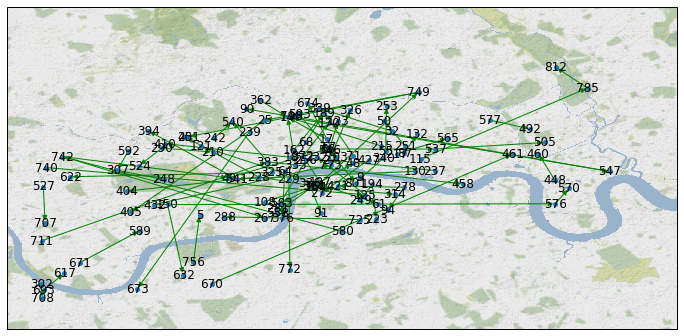

In [156]:
crs = ccrs.PlateCarree()
stamen_terrain = cimgt.StamenTerrain()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.add_image(stamen_terrain, 14)

ax.set_extent([-0.229396,0.023066,51.450152,51.571590])
nx.draw(jump_network,pos=stationPositions, with_labels = True, node_size=15,style='dotted',edge_color='green',arrows=True)

The graph of the journeys from the Santander Bike network's "busiest bike" in December 2016.

*Task 7*: Answer the following questions
- What does this map show?
- How could the figure be improved?

### Understanding popular routes on the Santander Bike network
To get a better picture of the most popular routes on the network, Python can very quickly run descriptiove statistics on large datasets (in our case, 6 million rows). Here, we calculate the most popular routes with the following function:
- using the `all_data` dataframe, run a `group_by()` function grouping the results by `StartStation Name`,`EndStation Name`
- count the number of trips made between these two stations
- sort the values using the arguement `ascending=False`
- show the top 10 most popular journeys on the network

In [157]:
Popular_routes = (all_data.groupby(['StartStation Name','EndStation Name'])
                  .count()
                  .sort_values(by='Bike Id',ascending=False))

Popular_routes.head(10)

Bike Id  \
StartStation Name                                 EndStation Name                                         
Black Lion Gate, Kensington Gardens               Palace Gate, Kensington Gardens                  3138   
Hyde Park Corner, Hyde Park                       Triangle Car Park, Hyde Park                     2806   
Palace Gate, Kensington Gardens                   Black Lion Gate, Kensington Gardens              2738   
Hyde Park Corner, Hyde Park                       Albert Gate, Hyde Park                           2717   
Black Lion Gate, Kensington Gardens               Hyde Park Corner, Hyde Park                      2715   
                                                  Albert Gate, Hyde Park                           2555   
Hyde Park Corner, Hyde Park                       Black Lion Gate, Kensington Gardens              2525   
Lee Valley VeloPark, Queen Elizabeth Olympic Park Aquatic Centre, Queen Elizabeth Olympic Park     2516   
Aquatic Centre, Queen Elizabeth Olympic Park      Podium, Queen Elizabeth Olympic Park             2494   
Podium, Queen Elizabeth Olympic Park              Aquatic Centre, Queen Elizabeth Olympic Park     2450   

                                                                                                Start Date  \
StartStation Name                                 EndStation Name                                            
Black Lion Gate, Kensington Gardens               Palace Gate, Kensington Gardens                     3138   
Hyde Park Corner, Hyde Park                       Triangle Car Park, Hyde Park                        2806   
Palace Gate, Kensington Gardens                   Black Lion Gate, Kensington Gardens                 2738   
Hyde Park Corner, Hyde Park                       Albert Gate, Hyde Park                              2717   
Black Lion Gate, Kensington Gardens               Hyde Park Corner, Hyde Park                         2715   
                                                  Albert Gate, Hyde Park                              2555   
Hyde Park Corner, Hyde Park                       Black Lion Gate, Kensington Gardens                 2525   
Lee Valley VeloPark, Queen Elizabeth Olympic Park Aquatic Centre, Queen Elizabeth Olympic Park        2516   
Aquatic Centre, Queen Elizabeth Olympic Park      Podium, Queen Elizabeth Olympic Park                2494   
Podium, Queen Elizabeth Olympic Park              Aquatic Centre, Queen Elizabeth Olympic Park        2450   

                                                                                                StartStation Id  \
StartStation Name                                 EndStation Name                                                 
Black Lion Gate, Kensington Gardens               Palace Gate, Kensington Gardens                          3138   
Hyde Park Corner, Hyde Park                       Triangle Car Park, Hyde Park                             2806   
Palace Gate, Kensington Gardens                   Black Lion Gate, Kensington Gardens                      2738   
Hyde Park Corner, Hyde Park                       Albert Gate, Hyde Park                                   2717   
Black Lion Gate, Kensington Gardens               Hyde Park Corner, Hyde Park                              2715   
                                                  Albert Gate, Hyde Park                                   2555   
Hyde Park Corner, Hyde Park                       Black Lion Gate, Kensington Gardens                      2525   
Lee Valley VeloPark, Queen Elizabeth Olympic Park Aquatic Centre, Queen Elizabeth Olympic Park             2516   
Aquatic Centre, Queen Elizabeth Olympic Park      Podium, Queen Elizabeth Olympic Park                     2494   
Podium, Queen Elizabeth Olympic Park              Aquatic Centre, Queen Elizabeth Olympic Park             2450   

                                                                                                End Date  \
S

Here we are showing the top 10 most popular routes on the network. 

*Task 8*:
- Which is the most popular route?
- How many times was the Hyde Park Corner, Hyde Park ->Black Lion Gate, Kensington Gardens route taken in December 2016?

### Thats all!
Thanks for attending this data wrangling workshop in Python. Start considering how some of these techniques can be useful in your every day life, for integregating data quickly and simply. I have also given you a flavour of the powerful `networkx` library, for those of you in the transportation space, as network data can be a lot different to other datasets. 

Please feel free to continue with the workshop material, and to leave some feedback over slack!